In [31]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import scipy

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AvgPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

In [32]:
# Define data directories
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

In [33]:
# Data exploration
train_class_counts = {}
for class_name in os.listdir(train_dir):
    train_class_counts[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))
print("Training Class Counts:", train_class_counts)


Training Class Counts: {'mountain': 2512, 'street': 2382, 'buildings': 2191, 'sea': 2274, 'forest': 2271, 'glacier': 2404}


In [34]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation/test data

In [36]:
batch_size = 32
image_size = (150, 150)

In [37]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse')  # Use 'sparse' for integer labels

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


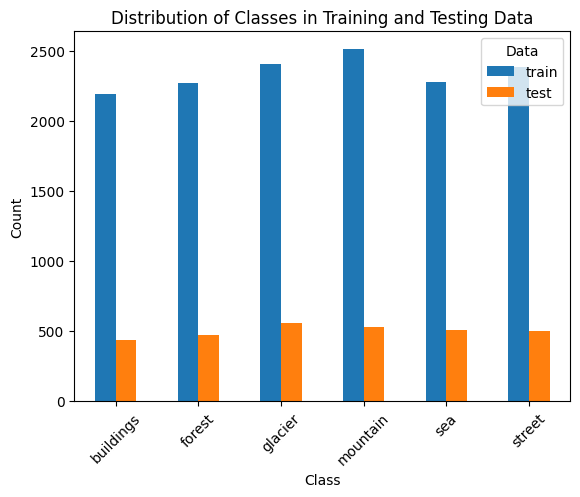

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the class indices from the generators
train_class_indices = train_generator.class_indices
test_class_indices = test_generator.class_indices

# Invert the dictionary to get class names
class_names = list(train_class_indices.keys())

# Get the counts of each class in the training and testing data
train_counts = train_generator.classes
test_counts = test_generator.classes

# Count occurrences of each class
train_class_counts = {class_name: sum(train_counts == train_class_indices[class_name]) for class_name in class_names}
test_class_counts = {class_name: sum(test_counts == test_class_indices[class_name]) for class_name in class_names}

# Create a DataFrame for visualization
df = pd.DataFrame({'train': train_class_counts, 'test': test_class_counts})

# Plot the bar chart
df.plot(kind='bar', rot=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training and Testing Data')
plt.legend(title='Data')
plt.show()


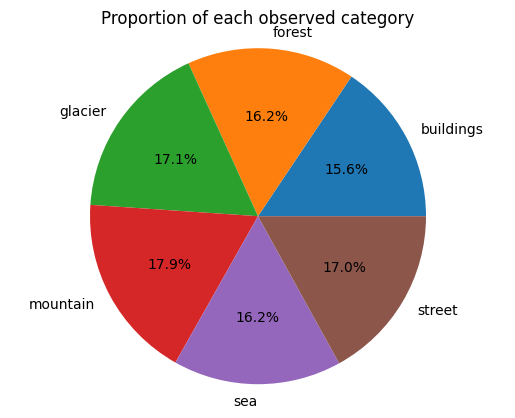

In [39]:
import matplotlib.pyplot as plt

# Get the class indices from the generators
train_class_indices = train_generator.class_indices

# Invert the dictionary to get class names
class_names = list(train_class_indices.keys())

# Get the counts of each class in the training data
train_counts = train_generator.classes

# Count occurrences of each class
train_class_counts = [sum(train_counts == train_class_indices[class_name]) for class_name in class_names]

# Plot the pie chart
plt.pie(train_class_counts,
        explode=(0, 0, 0, 0, 0, 0), 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()


In [40]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [41]:
idx_to_classes = {val:key for key, val in dict(train_generator.class_indices).items()}
idx_to_classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [42]:
# Build the CNN model
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # Adjust output units according to your number of classes
])


# # Build the CNN model
# model = tf.keras.models.Sequential([
#     # Convolution 1
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.AvgPool2D(pool_size=(3, 3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.3),
    
#     # Convolution 2
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.AvgPool2D(pool_size=(3, 3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.3),
    
#     # Convolution 3
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.AvgPool2D(pool_size=(3, 3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.3),
    
    
#     # Flatten & Linear Fully Connected Layers
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
    
#     # Output layer
#     tf.keras.layers.Dense(6, activation='softmax')
# ])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [43]:
# Compile the model
model.compile(optimizer='adam', # optimization algo
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, # no. of batches in each epoch
    epochs=80,  # Adjust number of epochs as needed
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)

Epoch 1/80


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/438 ━━━━━━━━━━━━━━━━━━━━ 27:27 4s/step - accuracy: 0.0625 - loss: 1.8021

W0000 00:00:1712518766.630384     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/438 ━━━━━━━━━━━━━━━━━━━━ 1:20 242ms/step - accuracy: 0.4002 - loss: 1.5084

W0000 00:00:1712518791.766912     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5006 - loss: 1.2590

W0000 00:00:1712518860.243233     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 103s 228ms/step - accuracy: 0.5008 - loss: 1.2586 - val_accuracy: 0.6875 - val_loss: 0.8327
Epoch 2/80
  1/438 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.5312 - loss: 1.0644

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.5312 - loss: 1.0644 - val_accuracy: 0.5000 - val_loss: 1.1326
Epoch 3/80


W0000 00:00:1712518866.633607     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 96s 215ms/step - accuracy: 0.6607 - loss: 0.8883 - val_accuracy: 0.7288 - val_loss: 0.7469
Epoch 4/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 48us/step - accuracy: 0.6875 - loss: 0.7487 - val_accuracy: 0.8333 - val_loss: 0.5059
Epoch 5/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 95s 213ms/step - accuracy: 0.7092 - loss: 0.7835 - val_accuracy: 0.7742 - val_loss: 0.6568
Epoch 6/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 0.6562 - loss: 0.7193 - val_accuracy: 0.8750 - val_loss: 0.5165
Epoch 7/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 95s 213ms/step - accuracy: 0.7349 - loss: 0.7188 - val_accuracy: 0.7681 - val_loss: 0.6303
Epoch 8/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.7500 - loss: 0.5114 - val_accuracy: 0.7083 - val_loss: 0.8441
Epoch 9/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 95s 213ms/step - accuracy: 0.7396 - loss: 0.6956 - val_accuracy: 0.7742 - val_loss: 0.6451
Epoch 10/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - accuracy: 0.7188 - loss: 0.8341 - val_accura

In [45]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

94/94 - 6s - 67ms/step - accuracy: 0.8637 - loss: 0.3998

Test accuracy: 0.8636666536331177


# Model Metrics

In [46]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
test_loss = history.history["val_loss"]
test_accuracy = history.history["val_accuracy"]

### Train Loss vs Validation Loss

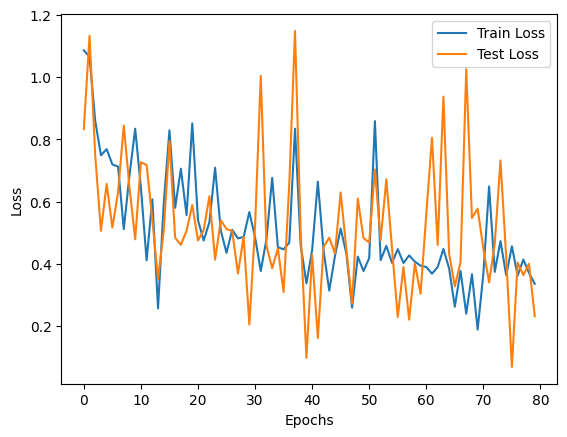

In [48]:
plt.plot(range(80), train_loss, label = "Train Loss")
plt.plot(range(80), test_loss, label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Train Accuracy vs Validation Accuracy

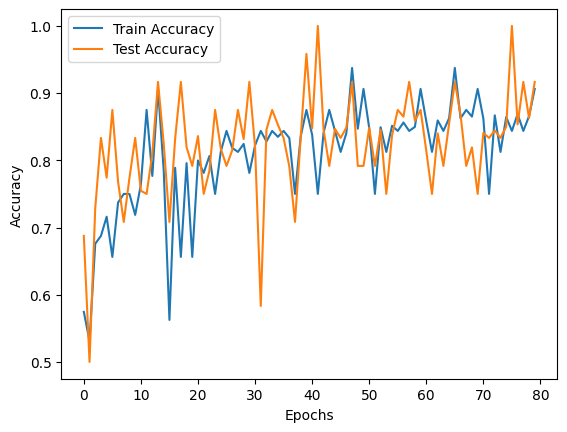

In [49]:
plt.plot(range(80), train_accuracy, label = "Train Accuracy")
plt.plot(range(80), test_accuracy, label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [50]:
pred_list = [rf"/kaggle/input/intel-image-classification/seg_pred/seg_pred/{i}" for i in os.listdir(r"/kaggle/input/intel-image-classification/seg_pred/seg_pred")]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


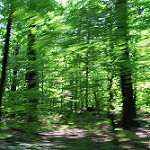

Model Prediction: forest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


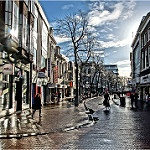

Model Prediction: street
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


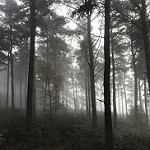

Model Prediction: forest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


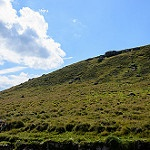

Model Prediction: forest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


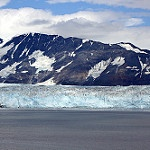

Model Prediction: glacier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


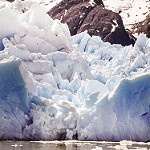

Model Prediction: glacier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


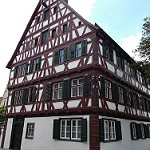

Model Prediction: buildings
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


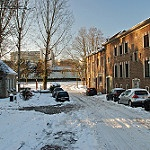

Model Prediction: street
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


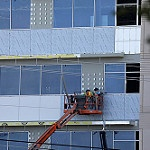

Model Prediction: buildings
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


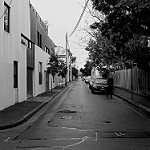

Model Prediction: street


In [53]:
from random import randint
from PIL import Image

# Function to preprocess and predict images
def preprocess_and_predict(image_path, model):
    img = Image.open(image_path)
    img = img.resize((150, 150))  # Resize image to match model input shape
    img_arr = np.array(img)  # Convert image to numpy array
    img_arr = img_arr / 255.0  # Normalize pixel values
    img_arr = img_arr[np.newaxis, :]  # Add batch dimension
    probability = model.predict(img_arr)  # Predict probabilities
    pred = np.argmax(probability)  # Get predicted class index
    return idx_to_classes[pred]  # Return predicted class label

# Generate random images and make predictions
for i in range(10):
    num = randint(0, len(pred_list))
    image_path = pred_list[num]
    predicted_class = preprocess_and_predict(image_path, model)
    
    # Display the image and predicted class
    img = Image.open(image_path)
    display(img)
    print("Model Prediction:", predicted_class)
    print("==========================================")
